In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.interpolate

pi = np.pi

The goal of this notebook is to build a routine that takes in an equation of state (or several) and produces mass/radius curves from the Tolmann-Oppenheiner-Volkov (TOV) equations. We begin with a brief introduction of the TOV equations. The TOV equations are two equations relating the energy density ($\epsilon$), pressure ($P$), and mass ($m$) of a neutron star. The first equation, shown below, is derived by solving the Einstein equations for a time-invariant, spherically symmetric metric

$$ \frac{dP}{dr} = - \frac{GM}{r^2} \epsilon \left( 1 + \frac{P}{\epsilon c^2} \right) \left( 1 + \frac{4\pi r^3 P}{Mc^2} \right) \left( 1 - \frac{2GM}{rc^2} \right)^{-1} $$

where $r$ is the radial coordinate and $G$ is the gravitational constant. The second equation is essentially conservation of energy/mass

$$ \frac{dM}{dr} = 4 \pi r^2 \rho $$

The energy density is related to the mass density by

$$ \epsilon = \rho + \frac{E}{N} n = \left( m_{N} + \frac{E}{N} \right)n $$

where $n$ is the baryon density, $m_{N}$ is the neutron mass, and $E/N$ is the energy per particle. To begin, we
will be using the polytropic equation of state (EOS) given by

$$ P(\rho) = K \rho^\Gamma $$

where $\Gamma$ is a dimensionless constant, and $K$ is a constant of proportionality. The first thing we do is, from an EOS, construct a three column array containing $\epsilon$, $\rho$, and $P$. We will also find it necessary to have the energy density as a function of the pressure. The mass density term is straightforward, but by using a thermodynamic relation

$$ P = n^2 \frac{\partial (E / N)}{\partial n} = \frac{\rho^2}{m_{N}}\frac{\partial (E / N)}{\partial \rho} \quad \implies \quad \frac{E}{N} = m_{N} \int \frac{P}{\rho^2} d\rho = \frac{Km_{N}\rho^{\Gamma-1}}{\Gamma -1} + C $$

where $C$ is the constant of integration. This constant is actually just the energy associated with the rest mass (aka the other term in our original expression). Thus we can say

$$ \epsilon(P) = \left( \frac{P}{K} \right)^{1/\Gamma} + \frac{P}{\Gamma-1} $$

In [27]:
def polytropic_EOS(K, Gamma, a_c, size):
    """
    This function will take in parameters for the polytropic equation of state (K and Gamma) as well as a size and
    output a table with three columns of length n.
    
    input:
    K: scalar parameter for EOS, units are determined by Gamma to make EOS have correct dimensions.
    Gamma: unitless scalar parameter for EOS, must be greater than 1.
    a_c: unitless scalar, factor multiplied by saturation density, determines highest density in table.
    size: unitless scalar, determines length of each column.
    
    output:
    table: 3xsize numpy array containing mass density(km^-2), pressure(km^-2), and energy density(km^-2)
    in units where c=G=1.
    """
    
    rho_s = 2e-4 #km^-2
    p_c = K*(a_c*rho_s)**Gamma
    
    #first we create a grid of mass density
    
    rho_c = a_c*rho_s
    rho = np.linspace(0, rho_c, size)
    p = K*(rho**Gamma)
    epsilon = rho + p/(Gamma-1)
    
    table = np.vstack((rho, p, epsilon))
    
    return table, p_c

Now that we have our table of inputs, let's simplify the differential equation we're working with. By introducing the variable $y = r^2$ the first TOV equation turns into

$$ \frac{dy}{dP} = - \frac{2yc^2}{G} \frac{\sqrt{y} - 2GM/c^2}{(c^2 \epsilon + P)(M + 4\pi y^{3/2} P/c^2)} $$

Note that we can make this switch because $r$ is the radial coordinate and only takes positive values. It will be convenient to work in units where $c = G = 1$ and we can do this by defining:

$$ p = \frac{G}{c^4}P \quad e = \frac{G}{c^2}\epsilon \quad m = \frac{G}{c^2} M $$

Next we rewrite this in terms of our $p$, $m$, and $e$ variables.

$$ \frac{dy}{dp} = \frac{-2y\left(\sqrt{y} - 2m\right) }{\left(e + p\right)\left(m + 4\pi y^{3/2} p\right)} $$

After this we can transform the total mass equation in the same way

$$ \frac{dm}{dr} = 4\pi r^2 \bar{\rho} = 4 \pi y \frac{G}{c^2} \left( \frac{P}{K} \right)^{1/\Gamma} $$

Please ignore the terrible notation. Now using the chain rule we get

$$ \frac{dm}{dp} = \frac{dm}{dr} \frac{dr}{dp} \quad \implies \quad \frac{dm}{dp} = \frac{ 4\pi e y^{3/2} \left( \sqrt{y} - 2m \right) }{\left( e + p \right) \left( m + 4\pi p y^{3/2} \right)} $$

Thus we have the two necessary equations to solve for $y$ and $m$. We label the two equations and define a vector, $V$ as:

$$ \begin{bmatrix} \frac{dy}{dp}\\ \frac{dm}{dp} \end{bmatrix} = \begin{bmatrix} f \\ g \end{bmatrix} \quad ; \quad V = \begin{bmatrix} y \\ m \end{bmatrix} \quad \implies \quad \frac{dV}{dp} = \begin{bmatrix} f \\ g \end{bmatrix}$$

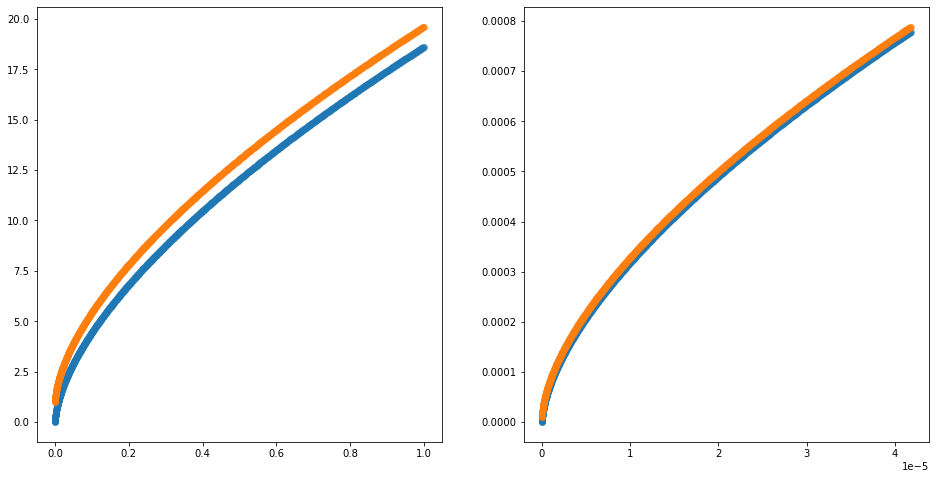

In [28]:
Gamma = 5/3
K = 7.3
a_c = 3.58
size = int(1e3)

EOS_table, p_c = polytropic_EOS(K, Gamma, a_c, size)

# grabbing relevant quantities
p_bar = EOS_table[1,:].reshape(size,)
e_bar = EOS_table[2,:].reshape(size,)

# nondimensionalized (incorrectly?)
p_til = EOS_table[1,:].reshape(size,)/p_c
e_til = EOS_table[2,:].reshape(size,)/p_c

# interpolates the table to get a function for the energy density
e_bar_func = scipy.interpolate.CubicSpline(p_bar, e_bar)
e_til_func = scipy.interpolate.CubicSpline(p_til, e_til)

# plot our interpolations over the table
fig, ax = plt.subplots(1,2, figsize= (16,8))

ax[0].plot(p_til,e_til, 'o', alpha=0.5)
ax[0].plot(p_til, e_til_func(p_til)+1, 'o', alpha=0.5)

ax[1].plot(p_bar,e_bar, 'o', alpha=0.5)
ax[1].plot(p_bar, e_bar_func(p_bar)+1e-5, 'o', alpha=0.5)

In [29]:
def func_dV(p_bar,V):
    """
    Function that characterizes the ODE we are solving.
    
    Inputs:
    p_bar: scalar input for pressure
    V: vector of (y, M_bar), np.array of shape(2,k)
    
    Outputs:
    dV = vector (f,g) defined above, np.array of shape (2,k) 
    """
    dV = np.zeros(V.shape)
    
    num0 = -2*V[0,:]*(np.sqrt(V[0,:])-2*V[1,:])
    den0 = (e_bar_func(p_bar)+p_bar)*(V[1,:]+4*pi*p_bar*V[0,:])
    
    dV[0,:] = num0/den0
    
    num1 = -4*np.pi*e_bar_func(p_bar)*(V[0,:]**(3/2))*(np.sqrt(V[0,:])-2*V[1,:])
    den1 = (e_bar_func(p_bar)+p_bar)*(V[1,:]+4*pi*p_bar*V[0,:])
    
    dV[1,:] = num1/den1
    
    return dV

<ipython-input-29-09a11d19df4b>:14: RuntimeWarning: invalid value encountered in sqrt
  num0 = -2*V[0,:]*(np.sqrt(V[0,:])-2*V[1,:])
<ipython-input-29-09a11d19df4b>:19: RuntimeWarning: invalid value encountered in power
  num1 = -4*np.pi*e_bar_func(p_bar)*(V[0,:]**(3/2))*(np.sqrt(V[0,:])-2*V[1,:])
<ipython-input-29-09a11d19df4b>:19: RuntimeWarning: invalid value encountered in sqrt
  num1 = -4*np.pi*e_bar_func(p_bar)*(V[0,:]**(3/2))*(np.sqrt(V[0,:])-2*V[1,:])


[0.70961572 0.7096157  0.70958064 0.70961713] [12.94679716 12.94843262 12.61923403 12.94803051]
[0.02898572 0.0289857  0.02895064 0.02898713] [ 0.25829716  0.25993262 -0.06926597  0.25953051]


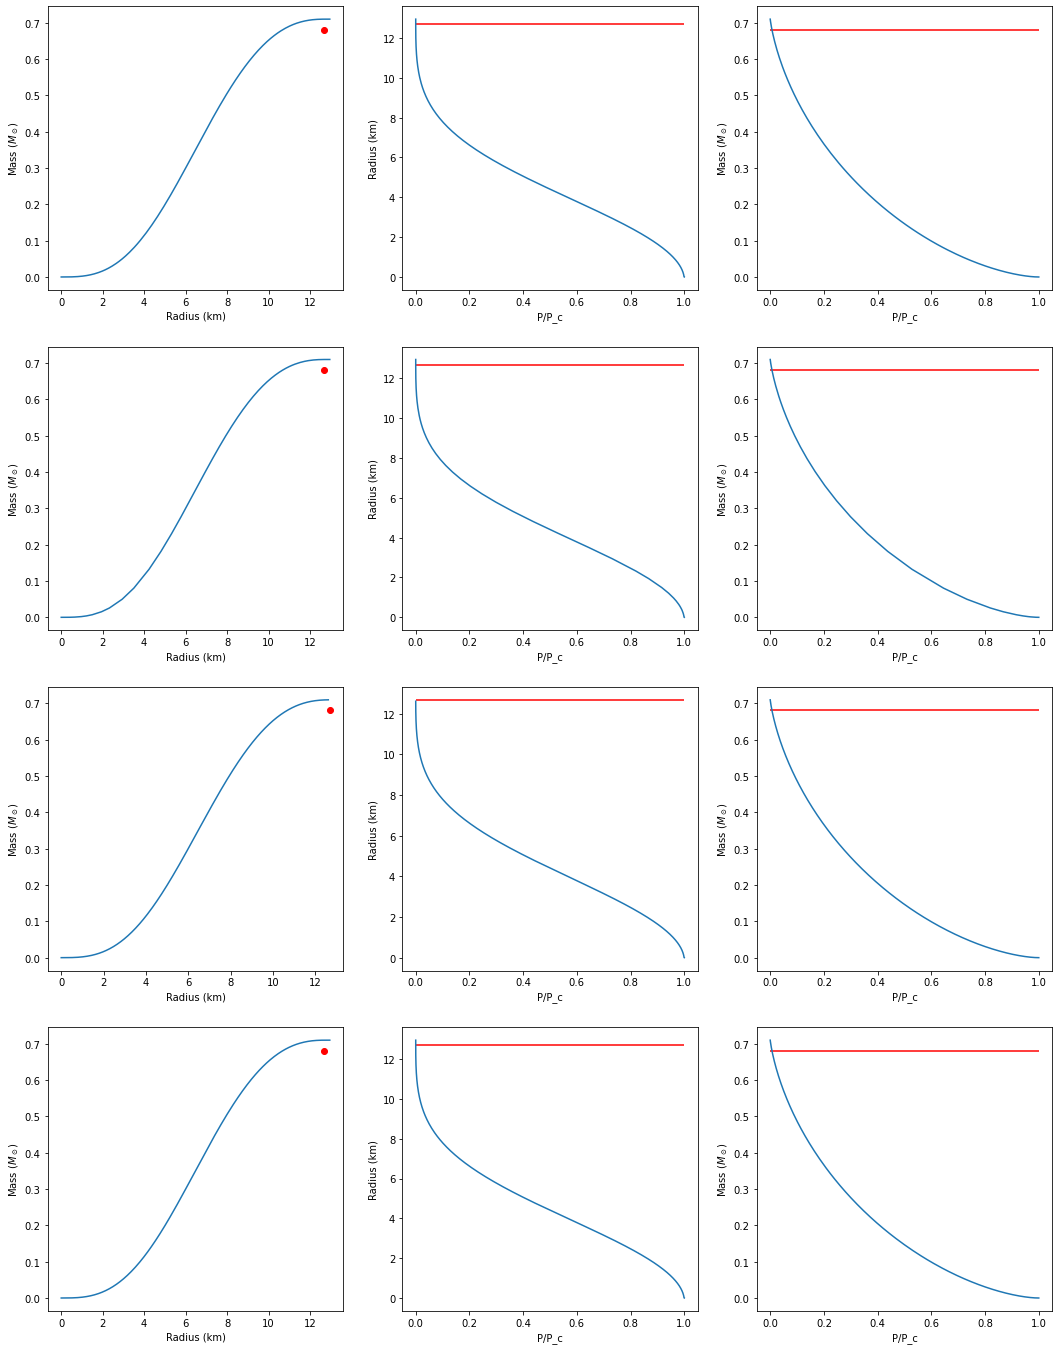

In [30]:
t0 = p_c
y0 = np.array([1e-9,1e-9])
t_bound = 1e-9*t0

steps = 1000
ndim = 2
nsolver = 4
solution = np.zeros((ndim, nsolver, steps))
pressure = np.zeros((nsolver, steps))

max_step = 1/steps
atol = 1e-10
rtol = 1e-10

RK45 = scipy.integrate.RK45(func_dV, t0, y0, t_bound, max_step=max_step,
                                    atol=atol, rtol=rtol, vectorized=True)

DOP853 = scipy.integrate.DOP853(func_dV, t0, y0, t_bound, max_step=max_step,
                                    atol=atol, rtol=rtol, vectorized=True)

BDF = scipy.integrate.BDF(func_dV, t0, y0, t_bound, max_step=max_step,
                                    atol=atol, rtol=rtol, vectorized=True)

LSODA = scipy.integrate.LSODA(func_dV, t0, y0, t_bound, max_step=max_step,
                                    atol=atol, rtol=rtol, vectorized=True)

solvers = [RK45, DOP853, BDF, LSODA]

radius_km = np.zeros((nsolver, steps))
mass_Mo = np.zeros((nsolver,steps))

max_r = np.zeros(nsolver)
max_m = np.zeros(nsolver)

j = 0
for solve in solvers:
    i = 0
    while i<steps and solve.t > 1e-12:

        solution[:,j,i] = solve.y
        pressure[j,i] = solve.t
        solve.step()
    
        i +=1
        
    max_step = i
    
    for k in range(ndim):
        solution[k,j,max_step:] = solution[k,j,max_step-1]
        # this just fixes any left over zeros if we don't take all the steps
    
    radius_km[j,:] = np.sqrt( solution[0,j,:] ) # convert to km
    mass_Mo[j,:] = solution[1,j,:]/1.4766 # convert to solar masses

    max_r[j] = np.max(radius_km[j,:]) # find maximums
    max_m[j] = np.max(mass_Mo[j,:])
    
    j +=1

ingo_r = 12.6885
ingo_m = 0.68063

fig, ax = plt.subplots(nsolver, 3, figsize = (18,24))

for j in range(nsolver):

    ax[j,0].plot(radius_km[j,:], mass_Mo[j,:])
    ax[j,0].set_xlabel('Radius (km)')
    ax[j,0].set_ylabel('Mass ($M_\odot$)')
    ax[j,0].plot(ingo_r, ingo_m, 'o', color='r')

    ax[j,1].plot(pressure[j,:]/p_c, radius_km[j,:])
    ax[j,1].set_xlabel('P/P_c')
    ax[j,1].set_ylabel('Radius (km)')
    ax[j,1].hlines(ingo_r, xmin=0, xmax=1, color='r')

    ax[j,2].plot(pressure[j,:]/p_c, mass_Mo[j,:])
    ax[j,2].set_xlabel('P/P_c')
    ax[j,2].set_ylabel('Mass ($M_\odot$)')
    ax[j,2].hlines(ingo_m, xmin=0, xmax=1, color='r')

# plt.savefig('MR_RP_MP.png')

print(max_m, max_r)
print(max_m-ingo_m, max_r-ingo_r)

## Tidal Polarizability

The tidal polarizability is given by $ \lambda = \frac{2R^5}{3G} k_2 $ where $k_2$ is the tidal Love number. We obtain the Love number by

$$ k_2 = \frac{8C^5}{5} \frac{ \left( 1 - 2C \right)^2 \left[ 2 - x_R + 2C(x_R -1) \right] }{2C\left[6-3x_R +3C(5x_R -8) \right] + 4C^3 \left[ 13 - 11x_R + C(3x_R -2) + 2C^2(1 + x_R) \right] + 3(1-2C)^2 \left[ 2 -x_R + 2C(x_R -1)  \right] \ln(1-2C) } $$

where $C = \frac{GM}{Rc^2} $ is the "compactness parameter". To find the value $x_R$ we need to solve

$$ r \frac{dx}{dr} + x^2 + xF + r^2 Q = 0 $$

with $x(0) = 2$ and $x_R = x(R)$. The functions $F$ and $Q$ are given by

$$ \begin{align} F &= \left[ 1 - \frac{4\pi r^2 G}{c^4} (\epsilon - P) \right] \left( 1 - \frac{2MG}{rc^2} \right)^{-1} \\ 
r^2 Q &= \frac{4\pi r^2 G}{c^4} \left[ 5\epsilon + 9P + \frac{\epsilon +P}{\frac{\partial P}{\partial \epsilon}} \right]\left( 1 - \frac{2MG}{rc^2} \right)^{-1} - 6 \left( 1 - \frac{2MG}{rc^2} \right)^{-1} - \frac{4M^2G^2}{r^2c^4} \left( 1 + \frac{4\pi r^3 P}{M c^2} \right)^2 \left( 1 - \frac{2MG}{rc^2} \right)^{-2} \end{align} $$

Now we move to our km$^{-2}$ units with $p$, $e$, and $m$ and also make this a function of pressure.

$$ \frac{dx}{dp} = \frac{(x^2 + xF + yQ)(\sqrt{y} - 2m)}{(e+p)(m + 4\pi y^{3/2} p)} $$

Doing this we also need to adjust our initial conditions for the function $x(P)$ to $x(p_c) = 2$, $x(0) = x_R$ and the functions $F$ and $Q$ become

$$ \begin{align} F &= \frac{\sqrt{y}}{\sqrt{y} - 2m} \big[ 1 - 4\pi y(e-p) \big] \\
yQ &= \frac{4\pi y^{3/2}}{\sqrt{y} - 2m} \left[ 5e + 9p + (e+p)\frac{\partial e}{\partial p}  \right]  - 6\frac{\sqrt{y}}{\sqrt{y} - 2m} - 4\left(\frac{m + 4\pi y^{3/2} p}{\sqrt{y} - 2m}\right)^2 \end{align} $$

Now we have all the math out of the way. Let's build a few functions to make this code easier.

In [31]:
def func_F(p,y,m):
    
    size = y.shape[0]
    p_vec = np.full(size, p)
    m_vec = np.full(size, m)
    
    a = np.sqrt(y)/(np.sqrt(y)-2*m_vec)
    b = 4*pi*(func_e(p_vec)-p_vec)
    return a*(1-b)

def func_yQ(p,y,m):
        
    size = y.shape[0]
    p_vec = np.full(size, p)
    m_vec = np.full(size, m)
    
    a = 4*pi*y*np.sqrt(y)
    b = np.sqrt(y)-2*m_vec
    
    one = (a/b)*(5*func_e(p_vec) + 9*p_vec + func_de(p_vec)*(func_e(p_vec)+p_vec))
    two = -6*np.sqrt(y)/b
    three = -4*( m_vec/b + a*p_vec/b )**2
    
    return one+two+three

def k_2(C, x_R):
    num = ((1 - 2*C)**2)*(2 - x_R + 2*C*(x_R-1))
    
    a = 6 - 3*x_R + 3*C*(5*x_R - 8)
    b = 13 - 11*x_R + C*(3*x_R-2) + (2*C**2)*(1+x_R)
    c = 2 - x_R + 2*C*(x_R-1)
    
    den = 2*C*a + 4*(C**3)*b + 3*((1-2*C)**2)*c*np.log(1-2*C)
    
    return (8*(C**5)*num)/(5*den)

def big_lamb(k2, R, M):
    """
    k2: dimensionless tidal Love number
    R: radius of NS in km
    M: mass of NS in Mo (solar masses)
    """
    return (2/3)*k2*((R/(1.4766*M))**5)

Text(0, 0.5, 'Energy Density Derivative Interpolation')

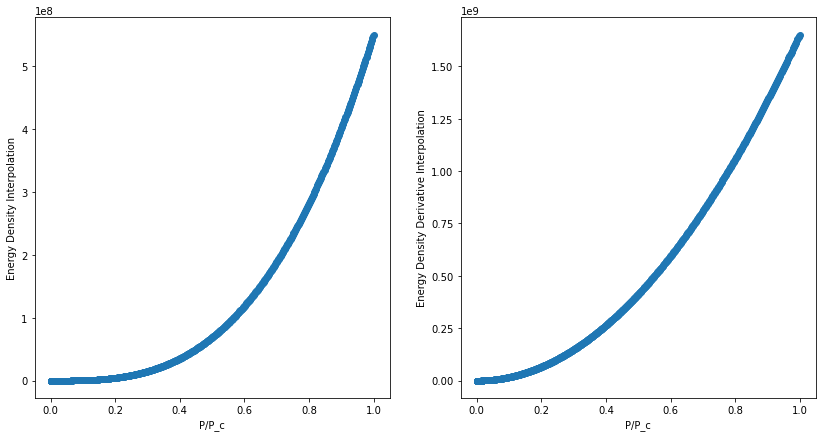

In [32]:
# let's get our energy density and its derivative

func_e = scipy.interpolate.CubicSpline(p_bar, e_bar)
func_de = scipy.interpolate.CubicSpline(p_bar, e_bar).derivative(nu=1)

fig, ax = plt.subplots(1,2, figsize=(14,7))

ax[0].plot(p_bar/p_c, func_e(p_bar/p_c), 'o')
ax[0].set_xlabel('P/P_c')
ax[0].set_ylabel('Energy Density Interpolation')

ax[1].plot(p_bar/p_c, func_de(p_bar/p_c), 'o')
ax[1].set_xlabel('P/P_c')
ax[1].set_ylabel('Energy Density Derivative Interpolation')

In [33]:
def func_dW(p,W):
    """
    Function that characterizes the ODE we are solving.
    
    Inputs:
    p_bar: scalar input for pressure
    W: vector of (y, m, x), np.array of shape(3,k)
    
    Outputs:
    dW = vector (f,g) defined above, np.array of shape (3,k) 
    """
    dW = np.zeros(W.shape)
    
    num0 = -2*W[0,:]*(np.sqrt(W[0,:])-2*W[1,:])
    den0 = (func_e(p)+p)*(W[1,:]+4*pi*p*W[0,:])
    
    dW[0,:] = num0/den0
    
    num1 = -4*pi*func_e(p)*(W[0,:]**(3/2))*(np.sqrt(W[0,:])-2*W[1,:])
    den1 = (func_e(p)+p)*(W[1,:]+4*pi*p*W[0,:])
    
    dW[1,:] = num1/den1
    
    num2 = (W[2,:]**2 + W[2,:]*func_F(p, W[0,:], W[1,:]) + func_yQ(p, W[0,:], W[1,:]) )*(np.sqrt(W[0,:])-2*W[1,:])
    den2 = (func_e(p)+p)*(W[1,:]+4*pi*p*W[0,:])
    
    dW[2,:] = num2/den2
    
    return dW

In [64]:
t0 = 0.5*p_c
y0 = np.array([1e-6,1e-6,2])
t_bound = 1e-12*p_c

steps = 1000
solution = np.zeros((y0.shape[0],steps))
pressure = np.zeros(steps)

max_step = 1e-8
atol = 1e-10
rtol = 1e-10

i=0

TOV_solution = scipy.integrate.RK45(func_dW, t0, y0, t_bound, max_step=max_step, vectorized=True)

while i<steps and TOV_solution.t > 1e-12:

    solution[:,i] = TOV_solution.y
    pressure[i] = TOV_solution.t
    TOV_solution.step()
    i +=1
    
last_index=i
print(i)

1000


In [65]:
# this is just a loop to fix my arrays in case the loop above finishes before i=steps

for j in range(y0.shape[0]):
    solution[j,last_index:] = solution[j,last_index-1]

# convert to our desired quantities
radius_km = np.sqrt( solution[0,:] )
mass_Mo = solution[1,:]/1.4766
x = solution[2,:]

max_radius = radius_km[last_index-1]
max_mass = mass_Mo[last_index-1]
x_R = x[last_index-1]

C = 1.4766*max_mass/max_radius
k2 = k_2(C, x_R)

Lamb = big_lamb(k2, max_radius, max_mass)

print(max_radius, max_mass, Lamb)

4.67612553229206 0.11443006517931345 381048.91765519243


Text(0, 0.5, 'x')

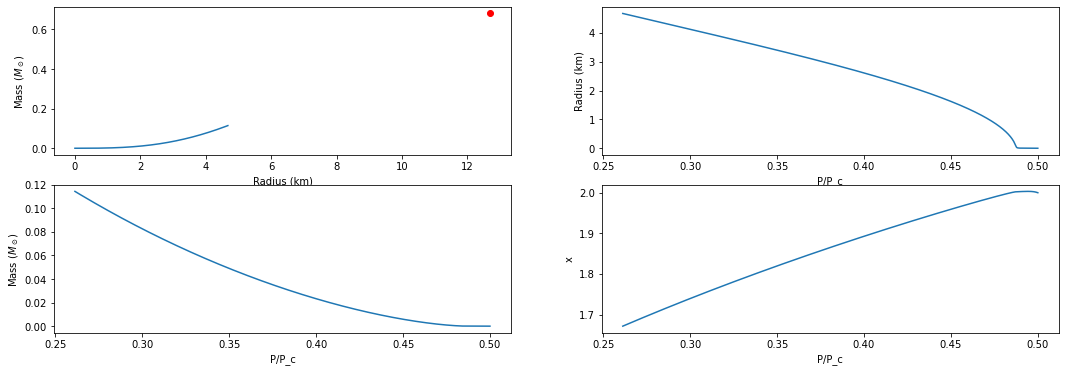

In [66]:
fig, ax = plt.subplots(2,2, figsize = (18,6))

ax[0,0].plot(radius_km, mass_Mo)
ax[0,0].set_xlabel('Radius (km)')
ax[0,0].set_ylabel('Mass ($M_\odot$)')
ax[0,0].plot(ingo_r, ingo_m, 'o', color='r')

ax[0,1].plot(pressure/p_c, radius_km)
ax[0,1].set_xlabel('P/P_c')
ax[0,1].set_ylabel('Radius (km)')

ax[1,0].plot(pressure/p_c, mass_Mo)
ax[1,0].set_xlabel('P/P_c')
ax[1,0].set_ylabel('Mass ($M_\odot$)')

ax[1,1].plot(pressure/p_c, x)
ax[1,1].set_xlabel('P/P_c')
ax[1,1].set_ylabel('x')

# plt.savefig('MR_RP_MP.png')

In [42]:
size = 1000
pcs = np.linspace(0.5*p_c, 1e4*p_c, size)
max_r = np.zeros(size)
max_m = np.zeros(size)
lamb = np.zeros(size)

for i in range(size):
    t0 = pcs[i]
    y0 = np.array([1e-6,1e-6,2])
    t_bound = 1e-12*t0

    steps = 1000
    solution = np.zeros((y0.shape[0],steps))
    pressure = np.zeros(steps)

    max_step = 1e-8
    atol = 1e-10
    rtol = 1e-10

    j=0

    TOV_solution = scipy.integrate.RK45(func_dW, t0, y0, t_bound, max_step=max_step,
                                        rtol=rtol, atol=atol, vectorized=True)

    while j<steps and TOV_solution.t > 1e-12:

        solution[:,j] = TOV_solution.y
        pressure[j] = TOV_solution.t
        TOV_solution.step()
        j +=1

    last_index=j
    # this is just a loop to fix my arrays in case the loop above finishes before i=steps

    for k in range(y0.shape[0]):
        solution[k,last_index:] = solution[k,last_index-1]

    # convert to our desired quantities
    radius_km = np.sqrt( solution[0,:] )
    mass_Mo = solution[1,:]/1.4766
    x = solution[2,:]

    max_r[i] = radius_km[last_index-1]
    max_m[i] = mass_Mo[last_index-1]
    x_R = x[last_index-1]

    C = 1.4766*max_m[i]/max_r[i]
    k2 = k_2(C, x_R)

    lamb[i] = big_lamb(k2, max_r[i], max_m[i])


<ipython-input-33-ad0320913c74>:14: RuntimeWarning: invalid value encountered in sqrt
  num0 = -2*W[0,:]*(np.sqrt(W[0,:])-2*W[1,:])
<ipython-input-33-ad0320913c74>:19: RuntimeWarning: invalid value encountered in power
  num1 = -4*pi*func_e(p)*(W[0,:]**(3/2))*(np.sqrt(W[0,:])-2*W[1,:])
<ipython-input-33-ad0320913c74>:19: RuntimeWarning: invalid value encountered in sqrt
  num1 = -4*pi*func_e(p)*(W[0,:]**(3/2))*(np.sqrt(W[0,:])-2*W[1,:])
<ipython-input-31-330e4b5c49b3>:7: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(y)/(np.sqrt(y)-2*m_vec)
<ipython-input-31-330e4b5c49b3>:17: RuntimeWarning: invalid value encountered in sqrt
  a = 4*pi*y*np.sqrt(y)
<ipython-input-31-330e4b5c49b3>:18: RuntimeWarning: invalid value encountered in sqrt
  b = np.sqrt(y)-2*m_vec
<ipython-input-31-330e4b5c49b3>:21: RuntimeWarning: invalid value encountered in sqrt
  two = -6*np.sqrt(y)/b
<ipython-input-33-ad0320913c74>:24: RuntimeWarning: invalid value encountered in sqrt
  num2 = (W[2,:]**2

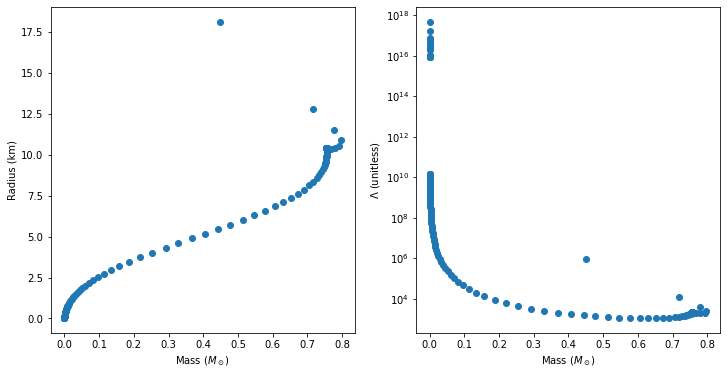

In [48]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(max_m, max_r, 'o')
ax[0].set_xlabel('Mass ($M_\odot$)')
ax[0].set_ylabel('Radius (km)')

ax[1].plot(max_m, lamb, 'o')
ax[1].set_xlabel('Mass ($M_\odot$)')
ax[1].set_ylabel('$\Lambda$ (unitless)')
ax[1].set_yscale('log')

In [67]:
mtoosmall = max_m < 0.1
print(pcs[mtoosmall].shape)

(861,)
